In [1]:
library(MASS)
library(tidyverse)
library(car)
library(emmeans)
library(wesanderson)
library(ggrepel)
library(fs)
library(ggridges)
library(data.table)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



# Pairwise urban-rural pi and Fst within cities

In this notebook, we'll examine urban-rural differences in diversity (theta_pi) and urban-rural Fst across all 26 cities. 

## Description of the data

- Low coverage individuals have been removed from these analyses, so we're using the samples that are part of the *finalSamples_lowCovRemoved* sample set from the previous analyses. 
- All analyses were performed using genome-wide 4-fold degenerate site.

The basic workflow is as follows:

1. Generate the Site Allele Frequency (SAF) likelihood distribution for each habitat within each city. 

    - Used the same filters as previously, the most important of which is that sites are only included if 50% of individuals have data. Remember, this is 50% of individuals _within_ a habitat; this would correspond to 5 individuals if none have been removed due to low coverage. 

2. To estimate diversity, generate the folded, one-dimensional SFS from the SAF file in step 1 and estimate diversity separately in urban and rural habitats
3. To estimate Fst, generate the folded, two-dimensional joint SFS of urban-rural habitats and estimate Fst. This uses only sites that are shared between both populations (i.e., the intersection of the two SAF files). 

    - For comparison, I estimated Fst using both Weir and Cockerham (1984) and Hudson (1992).
    
4. We also performed a permutation test for pi and Fst in each city by randomly permuting the urban and rural individuals and repeating steps 1 to 2 above

In [2]:
# Theme used for plotting
ng1 <- theme(aspect.ratio=0.7,panel.background = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border=element_blank(),
          axis.line.x = element_line(color="black",size=1),
          axis.line.y = element_line(color="black",size=1),
          axis.ticks=element_line(size = 1, color="black"),
          axis.ticks.length=unit(0.25, 'cm'),
          axis.text=element_text(color="black",size=15),
          axis.title=element_text(color="black",size=1),
          axis.title.y=element_text(vjust=2,size=17),
          axis.title.x=element_text(vjust=0.1,size=17),
          axis.text.x=element_text(size=15),
          axis.text.y=element_text(size=15),
          strip.text.x = element_text(size = 10, colour = "black",face = "bold"),
          strip.background = element_rect(colour="black"),
          legend.position = "top", legend.direction="vertical",
          legend.text=element_text(size=17), legend.key = element_rect(fill = "white"),
          legend.title = element_text(size=17),legend.key.size = unit(1.0, "cm"))

## Pairwise diversity

### Load diversity data

#### Observed

In [28]:
# Function to load observed diversity estimates by city and habitat
load_obs_pairwise_diversity <- function(path){
    
    # Get city and site names from file
    city <- dirname(path)
    site <- str_extract(basename(path), pattern = '(?<=_)[r|u]')
    
    full_path <- paste0(inpath, path)
    df <- suppressMessages(read_delim(full_path, delim = '\t')) %>% 
        mutate(tp_scaled = tP / nSites,
               tw_scaled = tW / nSites,
               city = city,
               habitat = site) %>% 
    dplyr::select(city, habitat, Chr, tp_scaled, tw_scaled, nSites)

    return(df)
    
}

In [33]:
# Merge diversity and habitat diversity dfs into single dataframe
inpath <- '../../../results/angsd/summary_stats/thetas/by_city/'
obs_div_df <- list.files(inpath, pattern = '.*_[u|r]_4fold.thetas.idx.pestPG', recursive = TRUE) %>% 
    map_dfr(., load_obs_pairwise_diversity)  %>% 
    group_by(city, habitat) %>% 
    summarise(tp_scaled = mean(tp_scaled),
              tw_scaled = mean(tw_scaled),
              nSites = sum(nSites)) %>% 
    ungroup()

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


In [34]:
head(obs_div_df)

city,habitat,tp_scaled,tw_scaled,nSites
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Albuquerque,r,0.01913512,0.02388864,231866
Albuquerque,u,0.01913369,0.02396646,232617
Antwerp,r,0.01940447,0.02608858,231124
Antwerp,u,0.01970166,0.02521575,232516
Armidale,r,0.01923786,0.02408274,234596
Armidale,u,0.01888040,0.02350858,232859


In [35]:
print(mean(obs_div_df$nSites))
print(range(obs_div_df$nSites))

[1] 229899.8
[1] 191599 236280


In [36]:
obs_div_df %>% filter(nSites == min(nSites) | nSites == max(nSites))

city,habitat,tp_scaled,tw_scaled,nSites
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Hiroshima,r,0.01857428,0.02348932,191599
Toronto,u,0.02023284,0.01981185,236280


In [40]:
betaLog_df <- suppressMessages(read_csv('../../phenotypic-analyses/analysis/supplementary-tables/allCities_logisticReg_coefs.csv'))
obs_div_df_wide <- obs_div_df %>% 
    # Calculate urban-rural difference in theta
    pivot_wider(names_from = habitat, values_from = c(tp_scaled, tw_scaled, nSites)) %>% 
    mutate(tp_diff = tp_scaled_u - tp_scaled_r) %>% 
    left_join(., betaLog_df, by = 'city') %>% 
    as.data.frame() %>% 
    mutate(city = fct_reorder(as.factor(city), betaLog_Dist),
           sig = case_when(betaLog_Dist > 0 & pvalLog_Dist < 0.05 ~ 'Significantly positive',
                           betaLog_Dist < 0 & pvalLog_Dist < 0.05 ~ 'Significantly negative',
                           TRUE ~ 'Not significant'),
          sigLog = ifelse(pvalLog_Dist < 0.05, 'Yes', 'No'))
head(obs_div_df_wide)

,city,tp_scaled_r,tp_scaled_u,tw_scaled_r,tw_scaled_u,nSites_r,nSites_u,tp_diff,yint_Dist,betaLog_Dist,pvalLog_Dist,yint_GMIS,betaLog_GMIS,pvalLog_GMIS,yint_hii,betaLog_hii,pvalLog_hii,continent,sig,sigLog
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,Albuquerque,0.01913512,0.01913369,0.02388864,0.02396646,231866,232617,-1.431574e-06,-0.825,-0.839,0.004,-1.236,0.021,0.955,-1.604,0.781,0.000,North America,Significantly negative,Yes
2,Antwerp,0.01940447,0.01970166,0.02608858,0.02521575,231124,232516,2.971930e-04,-2.234,2.150,0.000,-0.613,-2.196,0.000,-0.308,-1.674,0.000,Europe,Significantly positive,Yes
3,Armidale,0.01923786,0.01888040,0.02408274,0.02350858,234596,232859,-3.574697e-04,0.215,1.487,0.000,1.216,-2.224,0.000,0.892,-0.162,0.425,Oceania,Significantly positive,Yes
4,Athens,0.01874452,0.01907828,0.02276640,0.02385618,233471,232582,3.337597e-04,-0.586,1.565,0.000,0.295,-1.142,0.000,0.489,-0.858,0.000,North America,Significantly positive,Yes
5,Bogota,0.01875265,0.01896383,0.01929122,0.02023868,226181,231279,2.111750e-04,-0.865,0.839,0.014,-0.064,-1.087,0.000,-0.296,-0.152,0.598,South America,Significantly positive,Yes
6,Buenos_Aires,0.01843377,0.01838614,0.02205861,0.02128518,231336,233149,-4.762949e-05,1.129,0.015,0.950,1.052,0.220,0.461,1.024,0.271,0.400,South America,Not significant,No


#### Figure 4A

- Mean urban and rural pi with standard errors

In [41]:
# Colors for histograms
pal <- wes_palette('Darjeeling1', 5, type = 'discrete')
urban_col <- pal[4]
rural_col <- pal[2]
cols <- c(urban_col, rural_col)

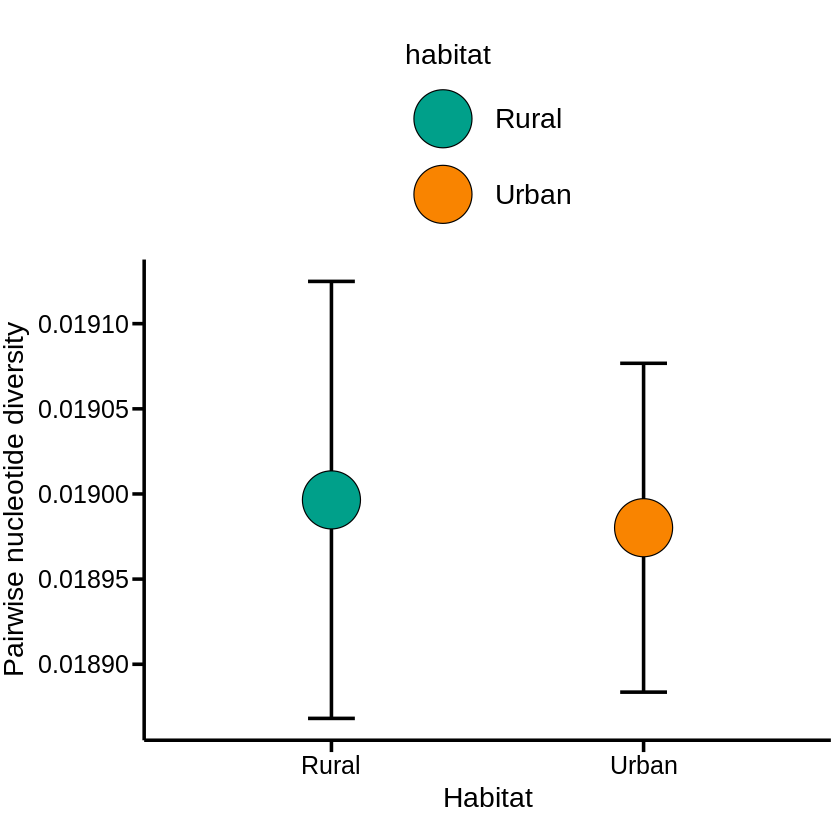

In [42]:
pi_by_habitat <- obs_div_df %>% 
    group_by(habitat) %>% 
    summarise(mean = mean(tp_scaled),
              sd = sd(tp_scaled),
              se = sd / sqrt(n())) %>% 
    mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u')) %>% 
    ggplot(., aes(x = habitat, y = mean, fill = habitat)) +
        geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.15, size = 1) +
        geom_point(size = 16, shape = 21) +
        scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
        ylab('Pairwise nucleotide diversity') + xlab('Habitat') +
    ng1
pi_by_habitat

In [39]:
outpath <- '../results/figures/main_text/figure_4/pi_observed_byHabitat_histogram_allCities.pdf'
ggsave(filename = outpath, plot = pi_by_habitat, device = 'pdf', width = 8, height = 10, units = 'in',
      useDingbats = FALSE, dpi = 600)

In [43]:
# Model testing for difference in pi between urban and rural habitats
pi_mod <- aov(tp_scaled ~ city + habitat, data = obs_div_df)
summary(pi_mod)

            Df    Sum Sq   Mean Sq F value   Pr(>F)    
city        25 1.368e-05 5.473e-07   4.447 0.000198 ***
habitat      1 3.000e-09 3.500e-09   0.028 0.868052    
Residuals   25 3.077e-06 1.231e-07                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [44]:
# Least squared means of pi in each habitat
emmeans(pi_mod, specs = 'habitat')

 habitat emmean       SE df lower.CL upper.CL
 r        0.019 6.88e-05 25   0.0189   0.0191
 u        0.019 6.88e-05 25   0.0188   0.0191

Results are averaged over the levels of: city 
Confidence level used: 0.95 

#### Figure 4B

- Slope of HCN cline vs. difference in pi

In [45]:
pal <- c("#909090", "#FF0000", "#046C9A")

`geom_smooth()` using formula 'y ~ x'


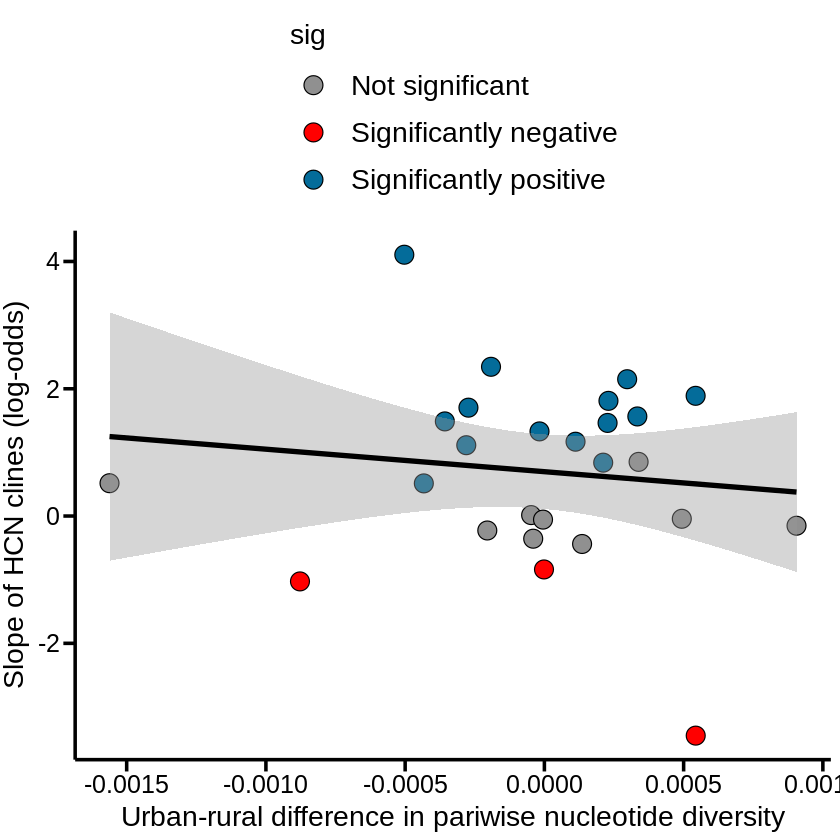

In [47]:
slope_by_PIdiff <- ggplot(obs_div_df_wide, aes(x = tp_diff, y = betaLog_Dist)) +
    geom_point(size = 5, aes(fill = sig), shape = 21) +
    geom_smooth(method = 'lm', color = 'black', size = 1.5) +
    scale_fill_manual(values = pal) +
    ylab('Slope of HCN clines (log-odds)') + xlab('Urban-rural difference in pariwise nucleotide diversity') +
    ng1
slope_by_PIdiff

In [17]:
outpath <- '../results/figures/main_text/figure_4/betaLog_vs_pi.pdf'
ggsave(filename = outpath, plot = slope_by_PIdiff, device = 'pdf', width = 8, height = 10, units = 'in',
      useDingbats = FALSE, dpi = 600)

In [49]:
# Model testing relationship between the slope of clines and the urban-rural difference in pi
div_mod <- aov(betaLog_Dist ~ tp_diff, data = obs_div_df_wide)
summary(div_mod)

            Df Sum Sq Mean Sq F value Pr(>F)
tp_diff      1   0.77  0.7687   0.367   0.55
Residuals   24  50.30  2.0960               

In [50]:
# Model testing whether the urban-rural difference in pi varies by whether there is a cline or not
tpDiff_by_sig_mod <- aov(tp_diff ~ sigLog, data = obs_div_df_wide)
summary(tpDiff_by_sig_mod)

            Df   Sum Sq   Mean Sq F value Pr(>F)
sigLog       1 4.00e-09 4.350e-09   0.017  0.897
Residuals   24 6.15e-06 2.562e-07               

In [51]:
emmeans(tpDiff_by_sig_mod, specs = 'sigLog')

 sigLog    emmean       SE df  lower.CL upper.CL
 No      1.45e-06 0.000169 24 -0.000347 0.000350
 Yes    -2.57e-05 0.000123 24 -0.000279 0.000228

Confidence level used: 0.95 

#### Figure 4C

- Permuted distribution of difference in pi by city with observed values overlaid

In [21]:
# Function to load permuted diversity estimates by city and habitat
load_permuted_pairwise_diversity <- function(path){
    
    # Get city and site names from file
    city <- dirname(dirname(path))
    site <- str_extract(basename(path), pattern = '(?<=_)[r|u]')
    seed <- str_extract(basename(path), pattern = '(?<=_seed)\\d+')

    
    full_path <- paste0(inpath, path)
    df <- suppressMessages(read_delim(full_path, delim = '\t')) %>% 
        mutate(tp_scaled = tP / nSites,
               tw_scaled = tW / nSites,
               city = city,
               habitat = site,
               seed = seed) %>% 
    dplyr::select(city, habitat, seed, tp_scaled, tw_scaled, nSites) %>% 
    group_by(city, habitat)

    return(df)
    
}

In [22]:
perm_div_df <- list.files(inpath, pattern = '.*_[u|r]_4fold_seed.*.thetas.idx.pestPG', recursive = TRUE) %>% 
    map_dfr(., load_permuted_pairwise_diversity) 

In [23]:
head(perm_div_df)

In [24]:
perm_div_df_wide <- perm_div_df %>% 
    # Calculate urban-rural difference in theta
    pivot_wider(names_from = habitat, values_from = c(tp_scaled, tw_scaled, nSites)) %>% 
    mutate(tp_diff = tp_scaled_u - tp_scaled_r) %>% 
    left_join(., betaLog_df, by = 'city')  %>% 
    as.data.frame() %>% 
    mutate(city = fct_reorder(as.factor(city), betaLog),
           sig = case_when(betaLog > 0 & pvalLog < 0.05 ~ 'Significantly positive',
                           betaLog < 0 & pvalLog < 0.05 ~ 'Significantly negative',
                           TRUE ~ 'Not significant'))
head(perm_div_df_wide)

### Plot differences in diversity

In [36]:
# Plot single permutation for Toronto
tor_divPerm <- perm_div_df_wide %>% 
    filter(city == 'Toronto') %>% 
    ggplot(., aes(x = tp_diff)) +
        geom_histogram(color = 'black', fill = 'white', bins = 25) +
        xlab('') + ylab('') +
        geom_vline(xintercept = obs_div_df_wide %>% filter(city == "Toronto") %>% pull(tp_diff),
                  linetype = 'dashed', color = 'Red') +
        ng1
tor_divPerm

In [37]:
outpath <- '../results/figures/Tor_divPerm.pdf'
ggsave(filename = outpath, plot = tor_divPerm, device = 'pdf', 
       width = 8, height = 8, units = 'in', dpi = 600, useDingbats = FALSE)

In [26]:
pal <- c("#909090", "#FF0000", "#046C9A")
piDiff_perm_byCity <- perm_div_df_wide %>% 
    ggplot(., aes(x = tp_diff, y = city, fill = sig)) +
    geom_density_ridges(scale = 1, show.legend = FALSE) +
    geom_segment(data = obs_div_df_wide, aes(x = tp_diff, xend = tp_diff, y = as.numeric(as.factor(city)), 
                                             yend = as.numeric(as.factor(city)) + 0.9),
                color = 'black', size = 0.9, linetype = 'dotted') +
    ylab('City') + xlab('Urban-rural difference in pairwise nucleotide diversity') +
    scale_fill_manual(values = pal) +
    scale_x_continuous(breaks = seq(from = -0.004, to = 0.004, by = 0.002)) +
    theme_classic() + theme(axis.line.x = element_line(color="black",size=1),
          axis.line.y = element_line(color="black",size=1),
          axis.ticks=element_line(color="black"),
          axis.text=element_text(color="black",size=15),
          axis.title=element_text(color="black",size=1),
          axis.title.y=element_text(vjust=2,size=17),
          axis.title.x=element_text(vjust=0.1,size=17),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          strip.text.x = element_text(size = 10, colour = "black",face = "bold"))
piDiff_perm_byCity

In [24]:
dir.create('../results/figures/main_text/figure_4')
outpath <- '../results/figures/main_text/figure_4/pi-diff_permutation_byCity.pdf'
ggsave(filename = outpath, plot = piDiff_perm_byCity, device = 'pdf', 
       width = 12, height = 12, units = 'in', dpi = 600, useDingbats = FALSE)

In [26]:
# Function to estimate P-values
permutation_pval <- function(df, var){
    
    city <- df %>% pull(city) %>% unique
    
    obs_val <- df %>% filter(is.na(seed)) %>% pull(var)
    perm_val <- df %>% filter(!(is.na(seed))) %>% pull(var)

    pval <- sum(abs(perm_val) >= abs(obs_val)) / 100
    df_out <- data.frame(city = city, pval = pval)
    return(df_out)
}

In [27]:
div_df <- bind_rows(obs_div_df_wide, perm_div_df_wide)
div_pval_df <- div_df %>% 
    group_split(city) %>% 
    purrr::map_dfr(., var = 'tp_diff', permutation_pval)

In [28]:
write_csv(div_pval_df, '../results/figures/tables/piDiff_permutations_pvalues.csv')

## Fst

### Load Fst dataframe

#### Observed

In [52]:
# Function to load observed Fst df by city/habitat
load_obs_fst <- function(path){
    
    # Get Fst type and city from filenames
    city <- dirname(path)
    
    full_path <- paste0(inpath, path)
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(fread(full_path, sep = '\t', header = FALSE, col.names = colnames)) %>% 
        
        # Cap numerators at 0 if negative 
        # https://github.com/ANGSD/angsd/issues/309
        # Does not affect overall pattern
        mutate(num = ifelse(num < 0, 0, num)) %>% 
        
        # Estimate weighted Fst as ratio of averages
        # https://github.com/ANGSD/angsd/issues/61
        summarise(num_sum = sum(num),
                  denom_sum = sum(denom),
                  fst = num_sum / denom_sum,
                  nSites = n()) %>% 
        mutate(city = city)
    
    return(df)
    
}

In [60]:
# Merge Fst dataframes. Only using Hudson's Fst
inpath <- '../../../results/angsd/summary_stats/hudson_fst/'
obs_fst_df <- list.files(inpath, pattern = '.*_4fold_r_u_readable.fst', recursive = TRUE) %>% 
    map_dfr(., load_obs_fst) %>% 
    left_join(., betaLog_df, by = 'city') %>% 
    as.data.frame() %>% 
    mutate(city = fct_reorder(as.factor(city), betaLog_Dist),
           sig = case_when(betaLog_Dist > 0 & pvalLog_Dist < 0.05 ~ 'Significantly positive',
                           betaLog_Dist < 0 & pvalLog_Dist < 0.05 ~ 'Significantly negative',
                           TRUE ~ 'Not significant')) 
# %>% 
#     filter(!(is.na(yint)))  # Remove Ac and Li locus estimates

In [61]:
head(obs_fst_df)

,num_sum,denom_sum,fst,nSites,city,yint_Dist,betaLog_Dist,pvalLog_Dist,yint_GMIS,betaLog_GMIS,pvalLog_GMIS,yint_hii,betaLog_hii,pvalLog_hii,continent,sig
,<dbl>,<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,34.08699,4073.558,0.008367866,229919,Albuquerque,-0.825,-0.839,0.004,-1.236,0.021,0.955,-1.604,0.781,0.000,North America,Significantly negative
2,24.71576,4126.987,0.005988815,229205,Antwerp,-2.234,2.150,0.000,-0.613,-2.196,0.000,-0.308,-1.674,0.000,Europe,Significantly positive
3,24.88437,4093.983,0.006078279,231597,Armidale,0.215,1.487,0.000,1.216,-2.224,0.000,0.892,-0.162,0.425,Oceania,Significantly positive
4,37.42994,4042.275,0.009259624,230919,Athens,-0.586,1.565,0.000,0.295,-1.142,0.000,0.489,-0.858,0.000,North America,Significantly positive
5,38.87932,3870.319,0.010045507,224076,Bogota,-0.865,0.839,0.014,-0.064,-1.087,0.000,-0.296,-0.152,0.598,South America,Significantly positive
6,28.64725,3913.134,0.007320793,229923,Buenos_Aires,1.129,0.015,0.950,1.052,0.220,0.461,1.024,0.271,0.400,South America,Not significant


In [62]:
# Mean Fst
obs_fst_df %>% 
    summarise(mean = mean(fst),
              sd = sd(fst),
              se = sd / sqrt(n()))

mean,sd,se
<dbl>,<dbl>,<dbl>
0.01193026,0.008459393,0.001659023


In [63]:
print(mean(obs_fst_df$nSites))
print(range(obs_fst_df$nSites))

[1] 225785.3
[1] 186401 235166


In [64]:
obs_fst_df %>% filter(nSites == min(nSites) | nSites == max(nSites))

num_sum,denom_sum,fst,nSites,city,yint_Dist,betaLog_Dist,pvalLog_Dist,yint_GMIS,betaLog_GMIS,pvalLog_GMIS,yint_hii,betaLog_hii,pvalLog_hii,continent,sig
<dbl>,<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
147.96018,3358.314,0.044057875,186401,Hiroshima,-0.865,-0.043,0.842,-1.303,0.947,0,-1.324,0.759,0,Asia,Not significant
24.35982,4428.828,0.005500285,235166,Toronto,-1.529,1.463,0.000,-0.442,-0.849,0,0.174,-1.292,0,North America,Significantly positive


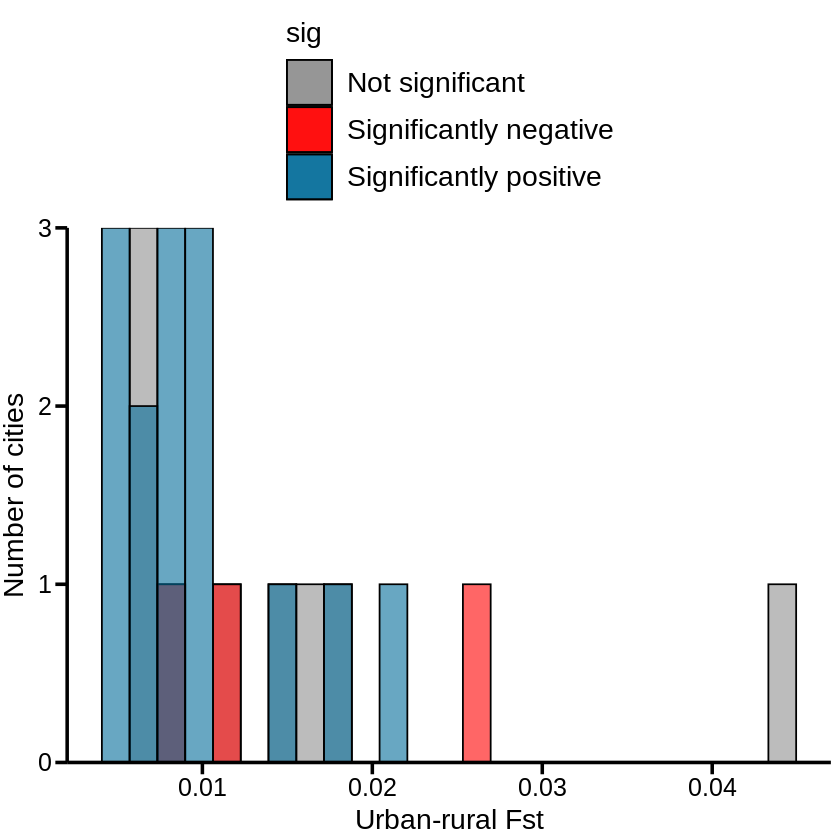

In [67]:
alpha <- 0.6
fst_by_cline <- ggplot(obs_fst_df, aes(x = fst)) +
    geom_histogram(data = obs_fst_df %>% filter(sig == 'Not significant'),
                                                         bins = 25, 
                                                         aes(fill = sig), 
                                                         color = 'black', 
                                                         alpha = alpha) +
    geom_histogram(data = obs_fst_df %>% filter(sig == 'Significantly negative'),
                                                         bins = 25, 
                                                         aes(fill = sig), 
                                                         color = 'black', 
                                                         alpha = alpha) +
   geom_histogram(data = obs_fst_df %>% filter(sig == 'Significantly positive'),
                                                         bins = 25, 
                                                         aes(fill = sig), 
                                                         color = 'black', 
                                                         alpha = alpha) +
    scale_fill_manual(values = pal) +
#     coord_cartesian(xlim = c(0, 0.22)) +
#     scale_x_continuous(breaks = seq(from = 0, to = 0.2, by = 0.05), expand = c(0, 0)) +
    ylab('Number of cities') + xlab('Urban-rural Fst') +
    
    scale_y_continuous(breaks = seq(from = 0, to = 6, by = 1), expand = c(0, 0)) +
    ng1
fst_by_cline

In [36]:
outpath <- '../results/figures/main_text/figure_4/fst_observed_histogram_allCities.pdf'
ggsave(filename = outpath, plot = fst_by_cline, device = 'pdf', width = 8, height = 10, units = 'in',
      useDingbats = FALSE, dpi = 600)

In [70]:
# Model testing whether Fst differs between cities with and without clines
fst_mod <- aov(fst ~ sig, data = obs_fst_df)
summary(fst_mod)

            Df    Sum Sq   Mean Sq F value Pr(>F)
sig          2 0.0001743 8.713e-05   1.241  0.308
Residuals   23 0.0016148 7.021e-05               

In [72]:
emmeans(fst_mod, specs = 'sig')

 sig                     emmean      SE df lower.CL upper.CL
 Not significant        0.01467 0.00279 23  0.00889   0.0204
 Significantly negative 0.01489 0.00484 23  0.00488   0.0249
 Significantly positive 0.00953 0.00224 23  0.00490   0.0142

Confidence level used: 0.95 

#### Figure 5C

- Slope of clines vs. Fst

`geom_smooth()` using formula 'y ~ x'


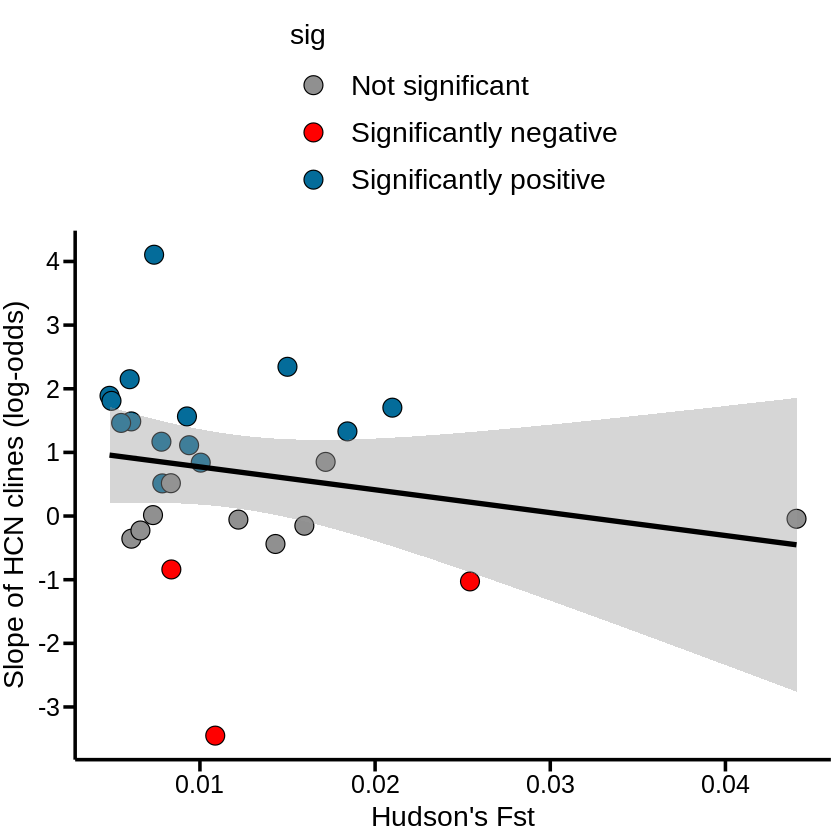

In [73]:
slope_by_fst <- ggplot(obs_fst_df, aes(x = fst, y = betaLog_Dist)) +
    geom_point(size = 5, aes(fill = sig), shape = 21) +
    geom_smooth(method = 'lm', color = 'black', size = 1.5) +
    scale_fill_manual(values = pal) +
    scale_y_continuous(breaks = seq(from = -4, to = 4, by = 1)) +
    ylab('Slope of HCN clines (log-odds)') + xlab("Hudson's Fst") +
    ng1
slope_by_fst

In [53]:
outpath <- '../results/figures/main_text/figure_4/betaLog_by_fst.pdf'
ggsave(filename = outpath, plot = slope_by_fst, device = 'pdf', width = 8, height = 10, units = 'in',
      useDingbats = FALSE, dpi = 600)

In [75]:
# Model testing whether Fst predicts the strength of clines
fst_mod <- aov(betaLog_Dist ~ fst, data = obs_fst_df)
summary(fst_mod)

            Df Sum Sq Mean Sq F value Pr(>F)
fst          1   2.31   2.310   1.137  0.297
Residuals   24  48.76   2.032               

#### Permuted

In [40]:
# Function to load permuted Fst df by city/habitat
load_perm_fst <- function(path){
    
    # Get Fst type and city from filenames
    city <- dirname(dirname(path))
    seed <- str_extract(basename(path), pattern = '(?<=_seed)\\d+')
    
    full_path <- paste0(inpath, path)
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(fread(full_path, sep = '\t', header = FALSE, col.names = colnames)) %>% 
        
        # Cap numerators at 0 if negative 
        # https://github.com/ANGSD/angsd/issues/309
        # Does not affect overall pattern
        mutate(num = ifelse(num < 0, 0, num)) %>% 
        
        # Estimate weighted Fst as ratio of averages
        # https://github.com/ANGSD/angsd/issues/61
        summarise(num_sum = sum(num),
                  denom_sum = sum(denom),
                  fst = num_sum / denom_sum,
                  nSites = n()) %>% 
        mutate(city = city,
               seed = seed)
    
    return(df)
    
}

In [41]:
# Merge Fst dataframes. Only using Hudson's Fst
inpath <- '../results/angsd/summary_stats/fst/fst1/'
perm_fst_df <- list.files(inpath, pattern = '.*seed\\d+_r_u_readable.fst', recursive = TRUE) %>% 
    map_dfr(., load_perm_fst) %>% 
    left_join(., betaLog_df, by = 'city') %>% 
    as.data.frame() %>% 
    mutate(city = fct_reorder(as.factor(city), betaLog),
           sig = case_when(betaLog > 0 & pvalLog < 0.05 ~ 'Significantly positive',
                           betaLog < 0 & pvalLog < 0.05 ~ 'Significantly negative',
                           TRUE ~ 'Not significant'))

In [116]:
fst_perm_byCity <- perm_fst_df %>% 
    ggplot(., aes(x = fst, y = city, fill = sig)) +
    geom_density_ridges(scale = 1, show.legend = FALSE) +
    geom_segment(data = obs_fst_df, aes(x = fst, xend = fst, y = as.numeric(as.factor(city)), 
                                             yend = as.numeric(as.factor(city)) + 0.9),
                color = 'black', size = 0.9, linetype = 'dotted') +
    ylab('City') + xlab('Urban-rural Fst') +
    scale_fill_manual(values = pal) +
    coord_cartesian(xlim = c(0, 0.22)) +
    scale_x_continuous(breaks = seq(from = 0, to = 0.2, by = 0.05)) +
    theme_classic() + theme(axis.line.x = element_line(color="black",size=1),
          axis.line.y = element_line(color="black",size=1),
          axis.ticks=element_line(color="black"),
          axis.text=element_text(color="black",size=15),
          axis.title=element_text(color="black",size=1),
          axis.title.y=element_text(vjust=2,size=17),
          axis.title.x=element_text(vjust=0.1,size=17),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          strip.text.x = element_text(size = 10, colour = "black",face = "bold"))
fst_perm_byCity

In [114]:
perm_fst_df %>% 
    filter(city == 'Toronto') %>% 
    ggplot(., aes(x = fst, y = city)) +
    geom_density_ridges(scale = 1, show.legend = FALSE) +
    geom_vline(xintercept = obs_fst_df %>% filter(city == 'Toronto') %>% pull(fst), linetype = 'dotted') +
    theme_classic()

In [75]:
dir.create('../results/figures/main_text/figure_5')
outpath <- '../results/figures/main_text/figure_5/fst_permutation_byCity.pdf'
ggsave(filename = outpath, plot = fst_perm_byCity, device = 'pdf', 
       width = 12, height = 12, units = 'in', dpi = 600, useDingbats = FALSE)

In [76]:
fst_df <- bind_rows(obs_fst_df, perm_fst_df)
fst_pval_df <- fst_df %>% 
    group_split(city) %>% 
    purrr::map_dfr(., var = 'fst', permutation_pval)

In [77]:
write_csv(fst_pval_df, '../results/figures/tables/fst_permutation_pvalues.csv')

## Euclidean distance from PCA

- Estimate Euclidean distance between urban and rural centroids by city

In [76]:
euclidean <- function(x1, y1, x2, y2){
    
    dist <- sqrt((x1 - x2)^2 + (y1 - y2)^2)
    return(dist)
}

In [77]:
# Load data with habitat info
habitat_info <- suppressMessages(
    read_delim(
        '../resources/glue_pc_sampleSheet.txt', 
                           delim = '\t')) %>% 
    dplyr::select(continent, range, city, pop, individual, site, sample)

In [85]:
# Load covariance matrix from PCAngsd
cov_mat <- suppressMessages(
    read_delim(
        '../../../results/population_structure/pcangsd/allSamples/allSamples_4fold_maf0.05_pcangsd.cov', 
                      col_names = FALSE, delim = ' ')) %>% 
      as.matrix()

# Combine continent and habitat data with sample order from ANGSD
samples <- suppressMessages(
    read_table(
        '../../../results/program_resources/bam_lists/finalSamples_4fold_bams.list', col_names = FALSE) %>% 
    rename('sample' = 'X1')) %>%
    mutate(sample = str_extract(sample, '(?<=4fold\\/)\\w+(?=_4fold)')) %>% 
    left_join(., habitat_info, by = 'sample')

In [86]:
head(samples)

sample,continent,range,city,pop,individual,site
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
Albuquerque_29_5,NAM,Introduced,Albuquerque,29,5,r
Albuquerque_29_9,NAM,Introduced,Albuquerque,29,9,r
Albuquerque_32_13,NAM,Introduced,Albuquerque,32,13,r
Albuquerque_32_3,NAM,Introduced,Albuquerque,32,3,r
Albuquerque_33_2,NAM,Introduced,Albuquerque,33,2,r
Albuquerque_33_7,NAM,Introduced,Albuquerque,33,7,r


In [87]:
# Dataframe with eigenvectors
eigenvectors <- eigen(cov_mat)
eigen_df <- eigenvectors$vectors %>% 
    as.data.frame() %>% 
    dplyr::select(V1, V2) %>% 
    rename('PC1' = 'V1',
         'PC2' = 'V2') %>% 
    bind_cols(., samples) %>% 
    mutate(sample_set = 'highErrorRemoved')

In [92]:
euc_dist_df <- eigen_df %>% 
    group_by(city, site) %>% 
    summarise(x = mean(PC1),
              y = mean(PC2)) %>% 
    pivot_wider(names_from = site, values_from = c(x, y)) %>% 
    mutate(distance = euclidean(x_u, y_u, x_r, y_r)) %>% 
    dplyr::select(city, distance) %>% 
    left_join(., betaLog_df, by = 'city')

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


In [93]:
head(euc_dist_df)

city,distance,yint_Dist,betaLog_Dist,pvalLog_Dist,yint_GMIS,betaLog_GMIS,pvalLog_GMIS,yint_hii,betaLog_hii,pvalLog_hii,continent
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Albuquerque,0.006470112,-0.825,-0.839,0.004,-1.236,0.021,0.955,-1.604,0.781,0.000,North America
Antwerp,0.005173246,-2.234,2.150,0.000,-0.613,-2.196,0.000,-0.308,-1.674,0.000,Europe
Armidale,0.003307576,0.215,1.487,0.000,1.216,-2.224,0.000,0.892,-0.162,0.425,Oceania
Athens,0.017485789,-0.586,1.565,0.000,0.295,-1.142,0.000,0.489,-0.858,0.000,North America
Bogota,0.007531273,-0.865,0.839,0.014,-0.064,-1.087,0.000,-0.296,-0.152,0.598,South America
Buenos_Aires,0.004265745,1.129,0.015,0.950,1.052,0.220,0.461,1.024,0.271,0.400,South America


### Does euclidean distance predict HCN?

In [94]:
dist_mod <- aov(betaLog_Dist ~ distance, data = euc_dist_df)
summary(dist_mod)

            Df Sum Sq Mean Sq F value Pr(>F)
distance     1   2.15   2.153   1.056  0.314
Residuals   24  48.92   2.038               

## Figure SX 

- PCA figure with urban/rural centroids

In [95]:
euc_dist_df_forPlot <- eigen_df %>% 
    group_by(city, site) %>% 
    summarise(x = mean(PC1),
              y = mean(PC2))
head(euc_dist_df_forPlot)

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


city,site,x,y
<chr>,<chr>,<dbl>,<dbl>
Albuquerque,r,0.001076591,0.016321967
Albuquerque,u,0.005727100,0.011823622
Antwerp,r,-0.005840701,0.010520384
Antwerp,u,-0.010582627,0.012588381
Armidale,r,0.013326773,-0.006951741
Armidale,u,0.014177276,-0.010148098


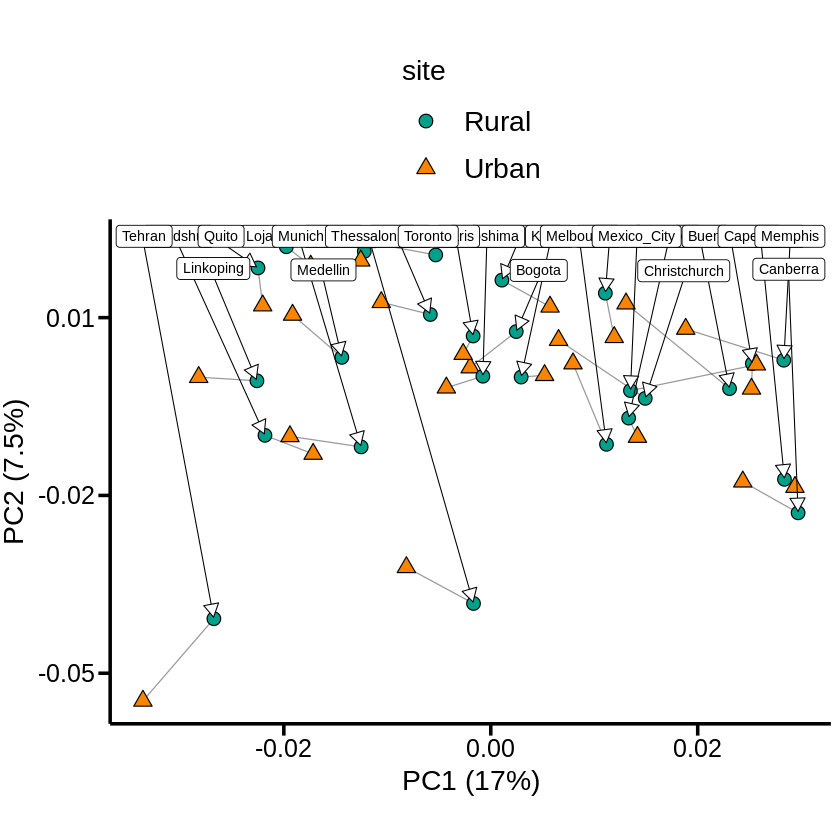

In [103]:
pca_centroids <- ggplot(euc_dist_df_forPlot, aes(x = x, y = y, fill = site, shape = site)) +
    geom_line(size = 0.35, alpha = 0.4, aes(group = city)) +
    geom_point(size = 3.5) +
    scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
    scale_shape_manual(values = c(21, 24), labels = c('Rural', 'Urban')) +
    scale_x_continuous(breaks = seq(from = -0.08, to = 0.06, by = 0.02)) +
    scale_y_continuous(breaks = seq(from = -0.05, to = 0.15, by = 0.03)) +
    ylab('PC2 (7.5%)') + xlab("PC1 (17%)") + 
    geom_label_repel(data = euc_dist_df_forPlot %>% filter(site == 'r'),
                     aes(label = city),
                        color = 'black',
                        fill = 'white', 
                        size = 3,
                        arrow = arrow(length = unit(0.03, "npc"), 
                        type = "closed", ends = "last"),
                        nudge_y = 0.1,
                        segment.size  = 0.3) +
    ng1
pca_centroids